In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pylab as pl
import seaborn as sns

In [ ]:
#Define test and train set
df = pd.read_csv("classification.csv")

In [ ]:
#See how training set looks like
df.head(5)

,event,url,date,title,sentence,Deaths,Injury,Location,Date,Time
0,assault,https://www.pennlive.com/news/2020/09/armed-an...,2020-09-01,‘Armed and dangerous’ man with ties to Carlisl...,A person not identified by police had suffered...,0,1,0,0,0
1,assault,https://www.pennlive.com/news/2020/09/armed-an...,2020-09-01,‘Armed and dangerous’ man with ties to Carlisl...,Officers went to the first block of West Willo...,0,0,1,1,1
2,assault,https://www.pennlive.com/news/2020/09/armed-an...,2020-09-01,‘Armed and dangerous’ man with ties to Carlisl...,Police are looking for a man they say was invo...,0,0,1,1,1
3,hurricane,https://www.wdtn.com/news/i-was-scared-for-him...,2020-09-01,‘I was scared for him’: Louisiana woman loses ...,"Breaux, of Lake Charles, was forced to go to a...",0,0,1,0,0
4,unrest,https://www.thedailybeast.com/family-protests-...,2020-09-01,"‘I’m Sad, I’m Mad’: L.A. Reels After Deputy Ki...","Ahmira Irene Roberson, a 22-year-old neighbor,...",0,0,0,1,1


In [ ]:
#Inspect Data for Train Set
print("Columns x Rows", df.shape)

Columns x Rows (2104, 10)


In [ ]:
#divide our training data into features X and label Y
train, test = train_test_split(df, test_size=0.1, random_state=42)
X_train = train['sentence'] #will be used to train our model on
X_test = test['sentence'] #will be used to predict the output labels to see how well our model has trained
y_train = train[['Deaths','Injury','Location','Date','Time']].values
y_test = test[['Deaths','Injury','Location','Date','Time']].values

In [ ]:
punct = '!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~“”'

In [ ]:
def clean_text(txt):
  txt = txt.strip() #remove additional white space before and after end of sentence
  # txt = txt.lower()
  txt = txt.replace("'s", "") # remove apostrophe s
  txt = txt.replace("\?a.m.", "am") # replace a.m.
  txt = txt.replace("\?p.m.", "pm") # replace p.m.
  text = "".join([c for c in txt if c not in punct]) #remove punct
  text = text.replace(u'\u2014', "")
  new_text = text.replace(r"\s+", " ") #remove additional space

  return new_text
  
x_train, x_test = [], []
for sentence in X_train:
  x_train.append(clean_text(sentence))

for sentence in X_test:
  x_test.append(clean_text(sentence))

In [ ]:
#Examine if data is properly split (i.e., is 90% of 153163)
train.describe()

,Deaths,Injury,Location,Date,Time
count,1893.000000,1893.000000,1893.000000,1893.000000,1893.00000
mean,0.341786,0.447438,0.590069,0.347068,0.29477
std,0.474433,0.497361,0.491951,0.476163,0.45606
min,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,1.000000,0.000000,0.00000
75%,1.000000,1.000000,1.000000,1.000000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.00000


Load BERT Tokenizer

In [ ]:
%pip install -q transformers==2.11.0

In [ ]:
#Import bert-base-cased
from transformers import BertTokenizer

model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
#Write function
import numpy as np
from tqdm.notebook import tqdm 

def encode_dataset(tokenizer, text_sequences, max_length):
    token_ids = np.zeros(shape=(len(text_sequences), max_length),
                         dtype=np.int32)
    for i, text_sequence in enumerate(tqdm(text_sequences)):
        #print(i)
        encoded = tokenizer.encode(text_sequence, max_length = 334, pad_to_max_length=True)
        token_ids[i, 0:len(encoded)] = encoded
    attention_masks = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_masks": attention_masks}

In [ ]:
#Tokenize all dataset needed for train, test and validation
encoded_train = encode_dataset(tokenizer, x_train, 334)
# encoded_val = encode_dataset(tokenizer, val_df["sentence"], 334)
encoded_test = encode_dataset(tokenizer, x_test, 334)

In [ ]:
encoded_train

{'attention_masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
 'input_ids': array([[  101,  1109,  4497, ...,     0,     0,     0],
        [  101, 26874,  1279, ...,     0,     0,     0],
        [  101,  1109,  1590, ...,     0,     0,     0],
        ...,
        [  101,  1109,  1168, ...,     0,     0,     0],
        [  101,  3284,  1132, ...,     0,     0,     0],
        [  101,  1124,  1173, ...,     0,     0,     0]], dtype=int32)}

Load BERT Model

In [ ]:
from transformers import TFBertModel
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Generate Model Structure
# the 2 inputs in data. See https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel
"""
a list of varying length with one or several input Tensors IN THE ORDER given in the docstring: model([input_ids, attention_mask])
"""
input_ids = keras.Input(shape=(334,), dtype='int32', name='input_ids')
attention_masks = keras.Input(shape=(334,), dtype="int32", name='attention_masks')
bert_base = TFBertModel.from_pretrained("bert-base-cased")
bert_base.trainable=False
sequence_output, pooled_output = bert_base([input_ids, attention_masks])
x = Dropout(0.1)(pooled_output)
out = Dense(5, activation='sigmoid')(x)


tmodel = Model(inputs=[input_ids, attention_masks], outputs=out)
tmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2, epsilon=1e-08),
                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                     metrics=['accuracy'])
# tmodel.compile(optimizer='adam', 
#                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#                metrics=['accuracy'])

tmodel.summary()
BATCH_SIZE = 128
history = tmodel.fit(encoded_train,y_train,epochs=10,batch_size=BATCH_SIZE,validation_split = 0.1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 334)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 334)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 334, 768), ( 108310272   input_ids[0][0]                  
                                                                 attention_masks[0][0]            
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 768)          0           tf_bert_model[0][1]          

In [ ]:
from keras.utils.vis_utils import plot_model
# plot_model(tmodel, to_file='BERT_Architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
max(history.history['accuracy'])

0.4310041069984436

In [ ]:
max(history.history['val_accuracy'])

0.5421052575111389

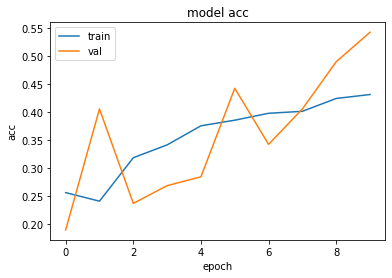

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

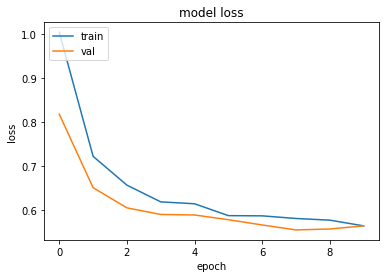

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
results = tmodel.evaluate(encoded_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

2/2 [==============================] - 5s 2s/step - loss: 0.5601 - accuracy: 0.5450
test loss, test acc: [0.5600968599319458, 0.5450236797332764]


In [ ]:
y_test[1:10]

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1],
       [1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [ ]:
#Do prediction with trained model for evaluation
predictions = tmodel.predict(encoded_test)
predictions[1:10]

array([[0.35553598, 0.8122998 , 0.3309973 , 0.09804321, 0.06630464],
       [0.40805832, 0.85138786, 0.18456316, 0.06810039, 0.02716101],
       [0.32987487, 0.5058601 , 0.74146897, 0.501043  , 0.46371213],
       [0.32728937, 0.49419907, 0.44769567, 0.18951987, 0.25624368],
       [0.5672862 , 0.6774875 , 0.28102294, 0.1425746 , 0.10427115],
       [0.38596156, 0.7440026 , 0.35947907, 0.18909605, 0.07891406],
       [0.6924637 , 0.5428584 , 0.27686548, 0.12885167, 0.07643713],
       [0.34515697, 0.8506655 , 0.16021986, 0.0567509 , 0.0289273 ],
       [0.31618923, 0.62642497, 0.44207504, 0.23068208, 0.21301652]],
      dtype=float32)

In [ ]:
# cm = confusion_matrix(y_test, predictions.round())
# ax= plt.subplot()
# sns.heatmap(cm, annot=True, ax = ax, fmt='.3g'); #annot=True to annotate cells
# # labels, title and ticks
# ax.set_xlabel('Predicted labels')
# ax.set_ylabel('True labels')
# ax.set_title('GloVe Confusion Matrix') 
# ax.xaxis.set_ticklabels(['Yes', 'No'])
# ax.yaxis.set_ticklabels(['Yes', 'No'])

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
print ("Batch Size: ", BATCH_SIZE)
print ("BERT Classification report: \n", (classification_report(y_test, predictions.round())))
print ("F1 micro averaging:",(f1_score(y_test, predictions.round(), average='micro')))

Batch Size:  128
BERT Classification report: 
               precision    recall  f1-score   support

           0       0.75      0.66      0.70        80
           1       0.47      0.93      0.62        91
           2       0.85      0.65      0.74       112
           3       0.62      0.07      0.13        71
           4       1.00      0.02      0.03        61

   micro avg       0.62      0.52      0.57       415
   macro avg       0.74      0.47      0.44       415
weighted avg       0.73      0.52      0.50       415
 samples avg       0.64      0.61      0.58       415

F1 micro averaging: 0.5688073394495413


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


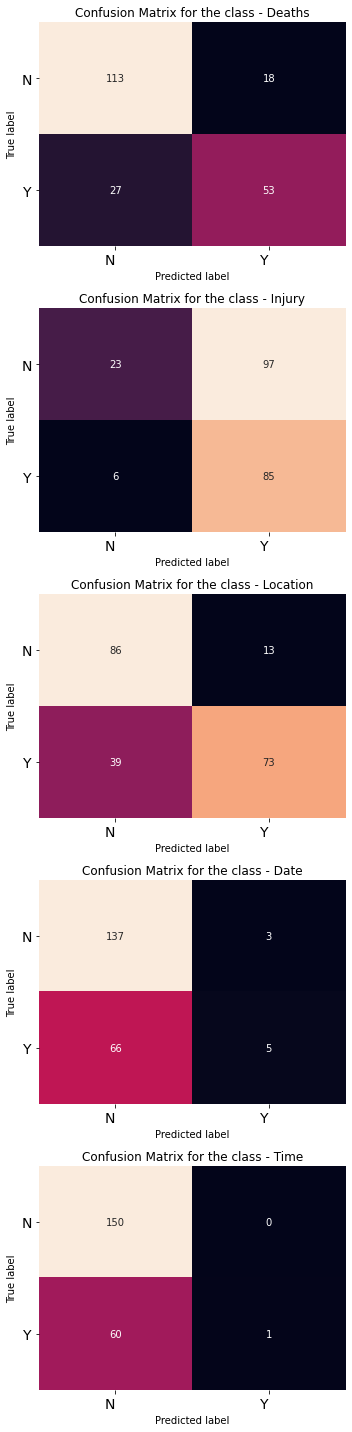

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
vis_arr = np.asarray(multilabel_confusion_matrix(y_test, predictions.round()))
labels = ['Deaths', 'Injury', 'Location', 'Date', 'Time']
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

fig, ax = plt.subplots(5, 1, figsize=(5, 20))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

In [ ]:
# tmodel.save_weights('BERT_B64_10.h5')